# Part 1. Regression
Predict house price based on its description.


## 0. Data Setup

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
USD_IN_UAH = 28.16 # on 20.09.2020


needed_columns = ['rooms', 'floor', 'building_floor_num', 'space', 'price', 'price_type']
sns.set_style('darkgrid')
dataset = pd.read_csv('data/real-estate-regression.csv')
dataset = dataset[needed_columns]
dataset.space = dataset.space.str.replace(',', '.').astype(float)
dataset.update(round(dataset.price / USD_IN_UAH, 2), filter_func=lambda _col: dataset.price_type == "грн" )
dataset = dataset.drop('price_type', axis = 1)
dataset.head()

,rooms,floor,building_floor_num,space,price
0,2,5,5,51.10,38000.00
1,2,9,16,65.14,34929.47
2,1,15,16,37.66,20729.05
3,1,12,16,40.61,21775.96
4,1,6,16,41.60,22306.82


## 1. Data investigation
(10 points)
Investigate meaning of features. Which features you would use for predictive
models and how they can be used? Which features to your mind should be more
important for prediction?  Analyse distribution of features and target variables.
Have a look on statistics. As visualization. For continuous features you can use
histograms and box plots, for categorical bar charts. Investigate outliers, is it
anomalies or just wrong values. Analyze correlations between features and target.
Write your conclusions about data.

Not relevant features:
- 'id' - the id is not related to the building at all
- 'house_type' - the same for all buildings in dataset
- 'name' - empty feature, not valuable
- 'hundret' - empty feature
- 'user' - the name say us nothing
- 'number' - not relevant
- 'description' - not valuable at all (could try to use the length of the description)
- 'street' - may be valuable but it will not give us much as the streets in Lviv usually are small
- 'agency' - could be helpful (can consider to use)
- 'region' - the same for all
- 'city' - the same for all
- 'house_type' - the same for all
- 'living_space' - included in total space (could be valuable)(missing data)
- 'kitchen_space' - included in total space (in most cases not the case of cost increase)(missing data)
- 'district' - the are different quartiles in districts and it is dataset dependent impact so it is is better to exclude
- 'date' - date of sell start (the longer it is in sell the cheaper it should be)
- 'walls_material' - the cheaper material the cheaper price for the building (not always the case)

Valuable Features:
- 'rooms' - directly increase the price
- 'floor' - is important for buyers(have impact on price)
- 'building_floor_num' -have some impact on price (the more floors it has the cheaper
is the price for m^2, true for Lviv)
- 'space' - directly increase the price

Target:
- 'price' - actual aim
- 'price_type' - should be used to cast data to one currency. most values are in $ and few are in 'грн' (UAH)
so it is reasonable convert all to $.

### Important Features for Prediction
Features: 'rooms', 'floor', 'building_floor_num', 'space'
Target: 'price' + 'price_type'

###  Distributions

array([<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>], dtype=object)

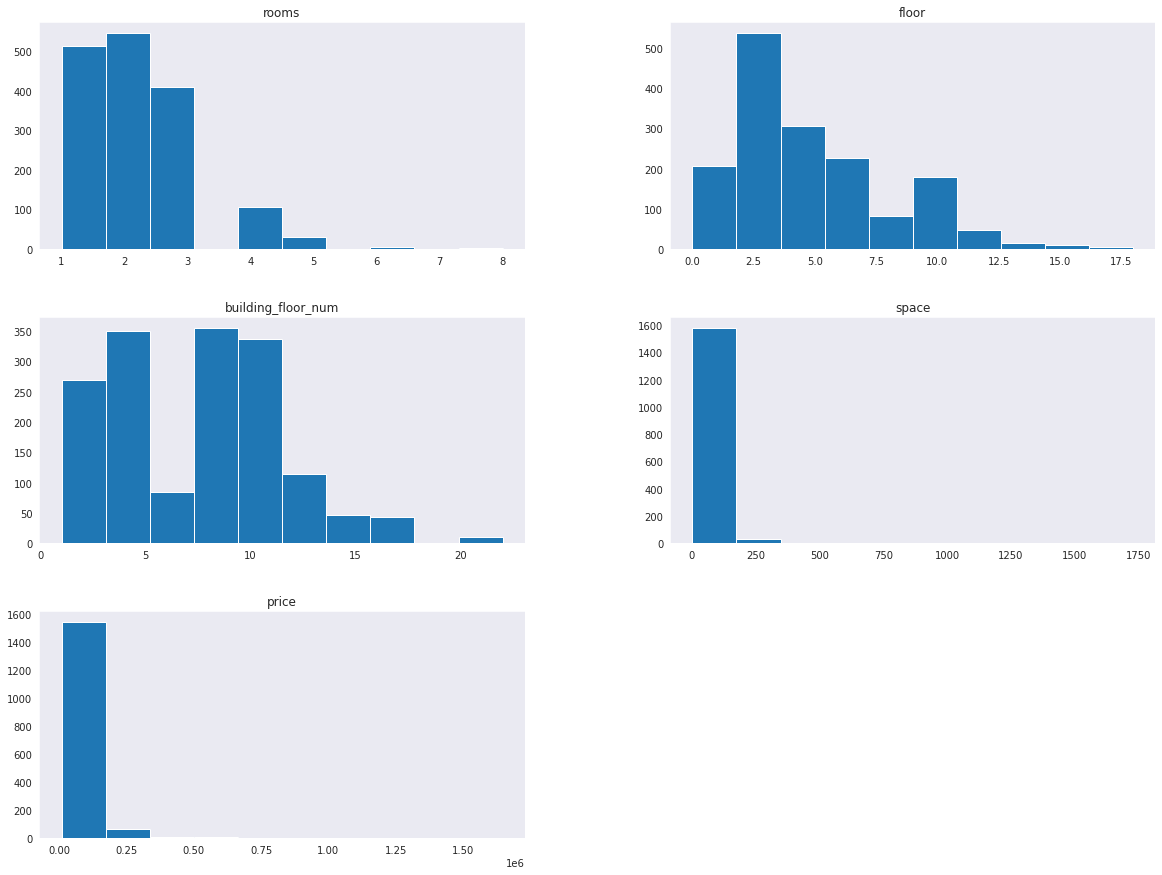

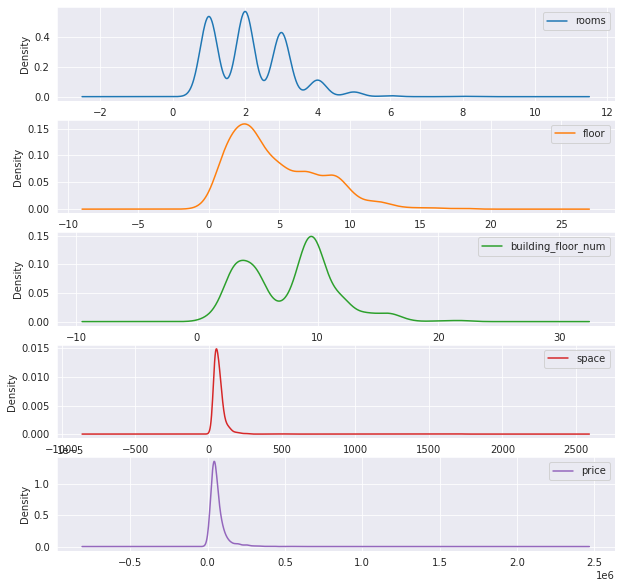

In [198]:
dataset.hist(figsize=(20, 15), grid=False)
dataset.plot(subplots=True, kind='density', sharex=False, figsize=(10, 10))

### Statistics
Have a look on statistics.
As visualization.

For continuous features you can use histograms and box plots
for categorical bar charts
Investigate outliers, is it anomalies or just wrong values.
Analyze correlations between features and target.

In [199]:
dataset.describe()

,rooms,floor,building_floor_num,space,price
count,1615.000000,1615.000000,1615.000000,1615.000000,1.615000e+03
mean,2.145511,4.756656,7.720743,70.457152,6.612498e+04
std,1.042114,3.197870,3.727311,55.375091,7.692620e+04
min,1.000000,0.000000,1.000000,2.000000,8.000000e+03
25%,1.000000,2.000000,4.000000,45.000000,3.591467e+04
50%,2.000000,4.000000,9.000000,62.000000,4.700000e+04
75%,3.000000,7.000000,10.000000,81.000000,7.281000e+04
max,8.000000,18.000000,22.000000,1729.000000,1.648000e+06


In [200]:
dataset.isnull().sum()

rooms                 0
floor                 0
building_floor_num    0
space                 0
price                 0
dtype: int64

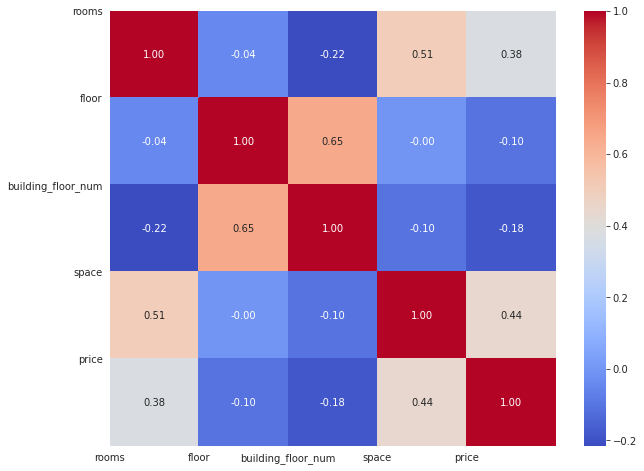

In [201]:
corr = dataset.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

After analyzing data I get the set of valuable features and target:
Features: 'rooms', 'floor', 'building_floor_num', 'space'
Target: 'price' + 'price_type'
Other columns are not so valuable. There are 2 empty columns, some columns
with with many empty cells and some columns with not needed data. Finally in the selected dataset the outliers
are not so critical. More details about columns are described higher.

## 2. Data preprocessing
(10 points)
Convert non-numerical features to dummy variables. Think what to do if you have
to many categories. Remove features if you wouldn't use it.
Deal with missing values.
Scale features or target if necessary.
Split dataset into train, test and cross validation sets.

- selected columns: 'rooms', 'floor', 'building_floor_num', 'space', 'price'
- transformed all prices to USD
- cast 'space' column to float

In [202]:
dataset.isnull().sum()

rooms                 0
floor                 0
building_floor_num    0
space                 0
price                 0
dtype: int64

In [203]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

X = dataset.drop(['price'], axis = 1).values
y = dataset['price'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [204]:
print("Shape of X_train:\t", X_train.shape)
print("Shape of X_test:\t", X_test.shape)
print("Shape of y_train:\t", y_train.shape)
print("Shape of y_test:\t", y_test.shape)

Shape of X_train:	 (1292, 4)
Shape of X_test:	 (323, 4)
Shape of y_train:	 (1292, 1)
Shape of y_test:	 (323, 1)


## 3. Training
(10 points)
Train linear regression, evaluate on validation set.
Train ridge and lasso regression, experiment with hyper-parameters.
Chose best model based on validation and test set.
Write which experiments give you the best results.

### Metric Import

In [205]:
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error

###  Linear Regression

In [206]:
# Creating the linear regressor
regressor_linear = LinearRegression()
regressor_linear.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
# Predicting Cross Validation Score the Test set results
cv_linear = cross_val_score(estimator = regressor_linear, X = X, y = y, cv = 10)

y_pred_linear_train = regressor_linear.predict(X_train)
score_linear_train = regressor_linear.score(X_train, y_train)

y_pred_linear_test = regressor_linear.predict(X_test)
score_linear_test = regressor_linear.score(X_test, y_test)

# Predicting RMSE the Test set results
print("CV: ", cv_linear.mean())
print('score (train): ', score_linear_train)
print('score (test): ', score_linear_test)

CV:  0.29619859773052093
score (train):  0.23808523991300024
score (test):  -0.9191658195788466


### Ridge Regression

In [207]:
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge())
]

ridge_pipe = Pipeline(steps)


# Applying Grid Search to find the best model and the best parameters
# step 1: alpha:[200, 230, 250,265, 270, 275, 290, 300, 500] -> 200
# step 2: alpha:[10,50,100,150,200] -> 50
# step 3: alpha: np.arange(30, 75, 1) -> 43

parameters =  {  'model__alpha' : [43],
                 'model__fit_intercept' : [True],
                 'model__tol' : [0.0001],
                 'model__solver' : ['auto'],
                'model__random_state': [42]
}
regressor_ridge = GridSearchCV(ridge_pipe, parameters, iid=False, cv=10)
regressor_ridge = regressor_ridge.fit(X, y.ravel())

print(regressor_ridge.best_score_)
print(regressor_ridge.best_params_)

-5.620642442591249
{'model__alpha': 43, 'model__fit_intercept': True, 'model__random_state': 42, 'model__solver': 'auto', 'model__tol': 0.0001}


/home/fenix/pr/ai_course/lab_1/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [208]:
# Predicting Cross Validation Score the Test set results
cv_ridge = regressor_ridge.best_score_

y_pred_ridge_train = regressor_ridge.predict(X_train)
score_ridge_train = regressor_ridge.score(X_train, y_train)

y_pred_ridge_test = regressor_ridge.predict(X_test)
score_ridge_test = regressor_ridge.score(X_test, y_test)

print('CV: ', cv_ridge.mean())
print('score (train): ', score_ridge_train)
print('score (test): ', score_ridge_test)


CV:  -5.620642442591249
score (train):  0.2593504581258832
score (test):  0.5322927902770254


### Ridge Regression

In [209]:
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Lasso())
]

lasso_pipe = Pipeline(steps)
# Applying Grid Search to find the best model and the best parameters
# step 1: alpha:np.arange(0.01, 1, 0.005) -> 0.9949

parameters =  {  'model__alpha' : [0.9949],
                 'model__fit_intercept' : [True],
                 'model__tol' : [0.0001],
                 'model__max_iter' : [5000],
                'model__random_state': [42]
}
regressor_lasso = GridSearchCV(lasso_pipe, parameters, iid=False, cv=10)
regressor_lasso = regressor_lasso.fit(X, y.ravel())

# Predicting Cross Validation Score
cv_lasso = regressor_lasso.best_score_

y_pred_lasso_train = regressor_lasso.predict(X_train)
score_lasso_train = regressor_lasso.score(X_train,y_train)

y_pred_lasso_test = regressor_lasso.predict(X_test)
score_lasso_test = regressor_lasso.score(X_test, y_test)

print('CV: ', cv_lasso.mean())
print('score (train): ', score_lasso_train)
print('score (test): ', score_lasso_test)

CV:  -9.331443836855179
score (train):  0.26262271013058824
score (test):  0.5297290010663728


/home/fenix/pr/ai_course/lab_1/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


### Best model for the dataset is Ridge Regression